# Model 3: using mixed data (satellite imagery and structured data) to predict where traffic accidents will happen

This notebook answers the question 'Does using satellite images increase the predictive capacity of a model to predict the location of traffic accidents?'

Model 1 used structured data on accidents, traffic and population density to predict the severity of traffic accidents. Model 2 used satellite imagery to train a CNN to predict whether a location would be a traffic accident hot-spot or not. In this notebook, model 3 will combine structured data and satellite imagery in a mixed-imput neural network, to attempt to improve the model's predictive capability.

Additional data was used for this model to get the LSOA for each latitude and longitude point, in order to match with the population data. The data is from the Greater London Authority Datastore, and contains the latitude and longitude centre point for each LSOA. Source: https://data.london.gov.uk/dataset/mylondon

## Obtaining and preparing the data

### Importing the data

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
from scipy.spatial import cKDTree
np.random.seed(123)
from shapely.ops import nearest_points
import geopandas
from math import *
import urllib, os
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from sklearn.preprocessing import MinMaxScaler
import glob
import cv2

from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate

from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, RMSprop
import argparse
import locale

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from keras import regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import load_model

In [204]:
accidents = pd.read_csv('data/modelling/London_accidents_merged.csv')
accidents.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf,Road,RCat
0,201301BS70003,-0.171402,51.486361,Serious,2,1,2013-01-02,Wednesday,A,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.000000,0.693147,E01002844,110.8,1634.4,860.4,14888.0,1139.8,2297.0,352.0,A3217,PA
1,201301BS70005,-0.173356,51.495115,Slight,1,2,2013-01-04,Friday,A,Single carriageway,30.0,Crossroads,A,Daylight,Other,Dry,Urban,8,8am-10am,Morning,Yes,Yes,Yes,0.693147,0.000000,E01002821,74.6,559.6,1516.0,28505.6,1396.2,3868.6,1003.0,A4,PA
2,201301BS70006,-0.210767,51.518353,Slight,1,1,2013-01-07,Monday,B,Single carriageway,30.0,Crossroads,B,Daylight,Fine no high winds,Dry,Urban,11,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.000000,E01002878,133.4,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
3,201301BS70007,-0.209675,51.516808,Slight,2,1,2013-01-10,Thursday,B,Single carriageway,30.0,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,10,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.693147,E01002831,179.2,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
4,201301BS70009,-0.194332,51.492922,Slight,2,1,2013-01-04,Friday,A,One way street,30.0,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,17,4pm-6pm,Rush hour,No,No,Yes,0.000000,0.693147,E01002851,272.3,869.2,1229.8,20478.6,897.2,4951.6,1251.4,A3220,PA


In [205]:
# This additional dataframe contains the latitude and longitude centre points for each LSOA
lsoa_latlong = pd.read_csv('data/geography/UK_LSOA_bounding_boxes.csv', usecols=['lsoa', 'Latitude', 'Longitude'])
lsoa_latlong.head()

,lsoa,Latitude,Longitude
0,E01000001,51.520269,-0.0950
1,E01000001,51.519848,-0.0967
2,E01000001,51.519030,-0.0962
3,E01000001,51.516904,-0.0981
4,E01000003,51.522376,-0.0973


In [206]:
population = pd.read_csv('data/population/Population_density.csv')
population.head()

,LSOA,population_per_hectare
0,E01012334,0.4
1,E01012335,12.1
2,E01012366,0.3
3,E01033481,9.3
4,E01033482,6.9


In [207]:
traffic = pd.read_csv('data/traffic/Traffic_averages.csv')
traffic.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf
0,51,49.915023,-6.317073,238.2,96.8,539.4,27.0,379.0,40.4
1,52,49.912343,-6.305686,87.4,79.4,629.0,9.0,221.8,11.0
2,53,49.917141,-6.306114,181.8,142.6,777.2,32.2,403.8,29.4
3,54,49.917810,-6.298996,61.2,54.8,342.8,6.0,251.6,34.4
4,55,49.918585,-6.295094,33.6,20.8,165.6,0.0,150.8,15.2


In [208]:
# Combining the motor vehicle traffic columns, based on the multi-collinearity found in model 1
to_sum = ['motorbike_aadf', 'car_aadf', 'bus_aadf', 'light_goods_vehicle_aadf', 'heavy_goods_vehicle_aadf']
traffic['motor_vehicle_aadf'] = traffic[to_sum].sum(axis=1)
traffic.drop(to_sum, axis=1, inplace=True)
traffic.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motor_vehicle_aadf
0,51,49.915023,-6.317073,238.2,1082.6
1,52,49.912343,-6.305686,87.4,950.2
2,53,49.917141,-6.306114,181.8,1385.2
3,54,49.917810,-6.298996,61.2,689.6
4,55,49.918585,-6.295094,33.6,352.4


### Creating the dataset of 'danger' locations (with traffic accidents)

In [8]:
def myround(x, base=.0005):
    return base * round(x/base)

In [9]:
# Adding rounded lat and long columns and a grid square column to the London accident dataset
accidents['lat_4dp'] = myround(accidents['Latitude'])
accidents['long_4dp'] = myround(accidents['Longitude'])
accidents['grid_square'] = round(accidents['lat_4dp'],4).map(str) + "," + round(accidents['long_4dp'],4).map(str)

In [19]:
# Take random sample of 20000 to drop duplicate grid squares
sample_20000_london = accidents.sample(n=20000, random_state=42, 
                                                     replace=False).drop_duplicates(['grid_square'])
len(sample_20000_london)

16218

In [20]:
# Now take random sample from above to get final sample of 10000 accidents
danger_london_accidents_sample = sample_20000_london.sample(n=10000, random_state=0, replace=False)
print(len(danger_london_accidents_sample))
danger_london_accidents_sample.head()

10000


,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,...,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf,Road,RCat,lat_4dp,long_4dp,grid_square
56476,2014450020376,-0.415736,51.338105,Slight,2,3,2014-11-29,Saturday,A,Dual carriageway,...,1048.4,62371.6,184.6,11286.0,2170.6,A3,TA,51.338,-0.4155,"51.338,-0.4155"
35882,201401KD50368,0.212878,51.592871,Slight,2,1,2014-07-26,Saturday,A,Roundabout,...,160.6,16451.0,363.4,1797.8,483.6,A118,PA,51.593,0.2130,"51.593,0.213"
16414,201301TX20055,-0.404606,51.477806,Slight,2,1,2013-02-09,Saturday,A,Dual carriageway,...,294.0,29316.2,706.4,3331.6,911.0,A4,PA,51.478,-0.4045,"51.478,-0.4045"
124923,2017010036052,-0.161815,51.466753,Slight,2,1,2017-04-10,Monday,Unclassified,Single carriageway,...,954.0,12590.6,95.4,2325.0,341.4,A3220,PA,51.467,-0.1620,"51.467,-0.162"
73930,201501SX20346,-0.231378,51.570964,Slight,2,1,2015-04-14,Tuesday,A,Roundabout,...,220.5,9388.0,389.0,2554.5,383.0,A5,PA,51.571,-0.2315,"51.571,-0.2315"


In [22]:
# Create model 3 dataset just consisting of traffic and population features
# Keep location features to get safe grid squares later
danger_squares = danger_london_accidents_sample[['Latitude', 'Longitude', 'population_per_hectare', 'bicycle_aadf', 
                                'motorbike_aadf', 'car_aadf', 'bus_aadf', 'light_goods_vehicle_aadf', 
                                'heavy_goods_vehicle_aadf', 'lat_4dp', 'long_4dp', 'grid_square']]

In [23]:
# Combine traffic features for motor vehicles like we did in model 1 notebook
to_sum = ['motorbike_aadf', 'car_aadf', 'bus_aadf', 'light_goods_vehicle_aadf', 'heavy_goods_vehicle_aadf']
danger_squares['motor_vehicle_aadf'] = danger_squares[to_sum].sum(axis=1)
danger_squares.drop(to_sum, axis=1, inplace=True)

In [25]:
# Getting columns in the right order
danger_squares = danger_squares[['grid_square', 'Latitude', 'Longitude', 'population_per_hectare', 
                                 'bicycle_aadf', 'motor_vehicle_aadf']]

# Rename columns for merging with safe dataset
danger_squares = danger_squares.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})

# Add safe column of all 0's due to being danger dataset
danger_squares['safe'] = 0

In [26]:
danger_squares.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
56476,"51.338,-0.4155",51.338105,-0.415736,3.8,2.6,77061.2,0
35882,"51.593,0.213",51.592871,0.212878,59.6,146.6,19256.4,0
16414,"51.478,-0.4045",51.477806,-0.404606,78.8,112.8,34559.2,0
124923,"51.467,-0.162",51.466753,-0.161815,142.2,1333.6,16306.4,0
73930,"51.571,-0.2315",51.570964,-0.231378,23.6,95.0,12935.0,0


In [44]:
# save dataset for model 3 notebook
danger_squares.to_csv('modelling/model3_danger_dataset.csv')

In [27]:
# Creating a list of danger squares to download using Google Static Maps API
model3_danger_squares = danger_squares.grid_square

### Creating the dataset of 'safe' locations (with no accidents)

In [212]:
# Getting a list of all possible locations
# Setting parameters
lat_min, lat_max = 51.257, 51.719
lon_min, lon_max = -0.542, 0.291
grid_size = 0.0005

# Getting a list of all grid squares
lats = np.linspace(lat_min, lat_max, 925)
lons = np.linspace(lon_min, lon_max, 1667)
coords = [(round(x,4),round(y,4)) for x in lats for y in lons]

# Converting to a dataframe and adding a column for the grid square name
coords = pd.DataFrame(coords, columns=['lat_4dp', 'long_4dp'])
coords['grid_square'] = coords['lat_4dp'].map(str) + "," + coords['long_4dp'].map(str)
coords.head()

,lat_4dp,long_4dp,grid_square
0,51.257,-0.5420,"51.257,-0.542"
1,51.257,-0.5415,"51.257,-0.5415"
2,51.257,-0.5410,"51.257,-0.541"
3,51.257,-0.5405,"51.257,-0.5405"
4,51.257,-0.5400,"51.257,-0.54"


In [213]:
# Creating a list of all squares
all_squares = coords.grid_square
len(all_squares)

1541975

In [214]:
# Creating a list of safe squares (all_squares minus danger_squares)
safe_squares = list(set(all_squares) - set(model3_dataset_danger))
print(len(safe_squares))
safe_squares = pd.DataFrame(safe_squares)
safe_squares.columns = ['grid_square']
safe_squares.head()

1472218


,grid_square
0,"51.422,0.2695"
1,"51.5485,-0.4945"
2,"51.3965,-0.327"
3,"51.668,0.0145"
4,"51.368,-0.405"


In [215]:
safe_squares_coords = safe_squares['grid_square'].str.split(',', expand=True)
safe_squares = pd.merge(safe_squares, safe_squares_coords, left_index=True, right_index=True)
safe_squares.columns = ['grid_square', 'latitude', 'longitude']
safe_squares.head()

,grid_square,latitude,longitude
0,"51.422,0.2695",51.422,0.2695
1,"51.5485,-0.4945",51.5485,-0.4945
2,"51.3965,-0.327",51.3965,-0.327
3,"51.668,0.0145",51.668,0.0145
4,"51.368,-0.405",51.368,-0.405


In [216]:
safe_squares[['latitude', 'longitude']] = safe_squares[['latitude', 'longitude']].astype(float)

#### Adding population density data to the safe squares

In order to find the correct population density for each row in the 'safe squares' dataset, it is necessary to match to the nearest LSOA on the basis of latitude and longitude. This is done in a similar manner to notebook 2, by finding the nearest neighbour LSOA centre point to each safe square location. To speed up the nearest neighbour matching process, the dataframes were first converted to Geopandas GeoDataFrames, which convert the latitudes and longitudes to Geopandas x and y Points. These points can then be used in the same cKDTree function as used in notebook 2.

In [217]:
# Converting to a GeoDataFrame
geo_safe_squares = geopandas.GeoDataFrame(safe_squares, geometry=geopandas.points_from_xy(safe_squares.latitude, safe_squares.longitude))
geo_safe_squares.head()

,grid_square,latitude,longitude,geometry
0,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695)
1,"51.5485,-0.4945",51.5485,-0.4945,POINT (51.5485 -0.4945)
2,"51.3965,-0.327",51.3965,-0.3270,POINT (51.3965 -0.327)
3,"51.668,0.0145",51.6680,0.0145,POINT (51.668 0.0145)
4,"51.368,-0.405",51.3680,-0.4050,POINT (51.368 -0.405)


In [218]:
# Converting to a GeoDataFrame
geo_lsoa_latlong = geopandas.GeoDataFrame(lsoa_latlong, geometry=geopandas.points_from_xy(lsoa_latlong.Latitude, lsoa_latlong.Longitude))
geo_lsoa_latlong.head()

,lsoa,Latitude,Longitude,geometry
0,E01000001,51.520269,-0.0950,POINT (51.52026933 -0.095)
1,E01000001,51.519848,-0.0967,POINT (51.51984806 -0.09669999999999999)
2,E01000001,51.519030,-0.0962,POINT (51.51902993 -0.09619999999999999)
3,E01000001,51.516904,-0.0981,POINT (51.51690356 -0.09810000000000001)
4,E01000003,51.522376,-0.0973,POINT (51.52237596 -0.0973)


In [219]:
def ckdnearest(gdA, gdB, bcol):   
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(float),
                             bcol : gdB.loc[idx, bcol].values })
    return df

In [220]:
# Finding the nearest LSOA for each safe square point
ckdnearest_lsoa = ckdnearest(geo_safe_squares, geo_lsoa_latlong, 'lsoa')

In [222]:
# Adding the name of the nearest LSOA to the safe squares list
safe_squares_merged = geo_safe_squares.join(ckdnearest_lsoa, how='left').drop('distance', axis=1)
safe_squares_merged = pd.merge(safe_squares_merged, lsoa_latlong, how='inner', on='lsoa')
len(safe_squares_merged)

1472218

In [224]:
safe_squares_merged.head()

,grid_square,latitude,longitude,geometry_x,lsoa,Latitude,Longitude,geometry_y
0,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.455248,0.193375,POINT (51.45524827 0.193374565)
1,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.459721,0.189846,POINT (51.45972081 0.1898461)
2,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.458117,0.189050,POINT (51.45811695 0.189049559)
3,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.457611,0.192048,POINT (51.45761125 0.192048342)
4,"51.4005,0.286",51.4005,0.2860,POINT (51.4005 0.286),E01000374,51.455248,0.193375,POINT (51.45524827 0.193374565)


Checking the distances are relatively close:

In [84]:
def distance_m(lat1, lon1, lat2, lon2):
    """Returns the distance in metres between two points described by latitudes and longitudes using the Haversine formula"""
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return (12742 * asin(sqrt(a)))*1000

# Calculating the distances between the accident and traffic count locations in each row
distances_m = []                    
for index, row in safe_squares_merged.iterrows():
    lat1 = row['latitude'] 
    lon1 = row['longitude'] 
    lat2 = row['Latitude'] 
    lon2 = row['Longitude'] 
    value = distance_m(lat1, lon1, lat2, lon2) 
    distances_m.append(value)

print("Mean:", round(np.mean(distances_m),1))
print("Median:", round(np.median(distances_m),1))
print("Minimum:", round(min(distances_m),1))
print("Maximum:", round(max(distances_m),1))

Mean: 3042.3
Median: 1038.7
Minimum: 0.0
Maximum: 21588.6


About half of LSOA centre points are 1km or less from the safe square locations, which is expected.

In [227]:
# Dropping unecessary columns
safe_squares_merged.drop(['Latitude', 'Longitude', 'geometry_x', 'geometry_y'], axis=1, inplace=True)

In [229]:
# Merging the safe squares dataset with the population density based on LSOA
safe_squares_merged = pd.merge(safe_squares_merged, population, how='left', left_on='lsoa', right_on='LSOA')

In [230]:
safe_squares_merged.head()

,grid_square,latitude,longitude,lsoa,LSOA,population_per_hectare
0,"51.422,0.2695",51.4220,0.2695,E01000374,E01000374,20.6
1,"51.4005,0.286",51.4005,0.2860,E01000374,E01000374,20.6
2,"51.4525,0.195",51.4525,0.1950,E01000374,E01000374,20.6
3,"51.454,0.1975",51.4540,0.1975,E01000374,E01000374,20.6
4,"51.404,0.2615",51.4040,0.2615,E01000374,E01000374,20.6


#### Adding traffic data to the safe squares

Traffic data is added using the same process as above.

In [231]:
geo_traffic = geopandas.GeoDataFrame(traffic, geometry=geopandas.points_from_xy(traffic['S Ref Latitude'], traffic['S Ref Longitude']))
geo_traffic.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motor_vehicle_aadf,geometry
0,51,49.915023,-6.317073,238.2,1082.6,POINT (49.91502292 -6.317072963999999)
1,52,49.912343,-6.305686,87.4,950.2,POINT (49.91234266 -6.305685679)
2,53,49.917141,-6.306114,181.8,1385.2,POINT (49.91714081 -6.306113756)
3,54,49.917810,-6.298996,61.2,689.6,POINT (49.91781028 -6.298996455)
4,55,49.918585,-6.295094,33.6,352.4,POINT (49.91858504 -6.295093656000001)


In [233]:
geo_safe_squares_merged = geopandas.GeoDataFrame(safe_squares_merged, geometry=geopandas.points_from_xy(safe_squares_merged['latitude'], safe_squares_merged['longitude']))
geo_safe_squares_merged.head()

,grid_square,latitude,longitude,lsoa,LSOA,population_per_hectare,geometry
0,"51.422,0.2695",51.4220,0.2695,E01000374,E01000374,20.6,POINT (51.422 0.2695)
1,"51.4005,0.286",51.4005,0.2860,E01000374,E01000374,20.6,POINT (51.4005 0.286)
2,"51.4525,0.195",51.4525,0.1950,E01000374,E01000374,20.6,POINT (51.4525 0.195)
3,"51.454,0.1975",51.4540,0.1975,E01000374,E01000374,20.6,POINT (51.454 0.1975)
4,"51.404,0.2615",51.4040,0.2615,E01000374,E01000374,20.6,POINT (51.404 0.2615)


In [234]:
ckdnearest_traffic = ckdnearest(geo_safe_squares_merged, geo_traffic, 'CP')
ckdnearest_traffic.head()

,distance,CP
0,0.010306,16092
1,0.027768,945657
2,0.007512,17832
3,0.006399,73051
4,0.013956,945571


In [236]:
final_safe_squares_merged = geo_safe_squares_merged.join(ckdnearest_traffic, how='left', rsuffix='_traffic')
print(len(final_safe_squares_merged))
final_safe_squares_merged.head()

1472218


,grid_square,latitude,longitude,lsoa,LSOA,population_per_hectare,geometry,distance,CP
0,"51.422,0.2695",51.4220,0.2695,E01000374,E01000374,20.6,POINT (51.422 0.2695),0.010306,16092
1,"51.4005,0.286",51.4005,0.2860,E01000374,E01000374,20.6,POINT (51.4005 0.286),0.027768,945657
2,"51.4525,0.195",51.4525,0.1950,E01000374,E01000374,20.6,POINT (51.4525 0.195),0.007512,17832
3,"51.454,0.1975",51.4540,0.1975,E01000374,E01000374,20.6,POINT (51.454 0.1975),0.006399,73051
4,"51.404,0.2615",51.4040,0.2615,E01000374,E01000374,20.6,POINT (51.404 0.2615),0.013956,945571


In [237]:
final_safe_squares_merged = pd.merge(final_safe_squares_merged, traffic, how='left', on='CP')

In [240]:
final_safe_squares_merged.drop(['lsoa', 'geometry_x', 'distance', 'CP', 'geometry_y'], axis=1, inplace=True)

In [101]:
# Calculating the distances between the accident and traffic count locations in each row
distances_m = []                    
for index, row in final_safe_squares_merged.iterrows():
    lat1 = row['latitude'] 
    lon1 = row['longitude'] 
    lat2 = row['S Ref Latitude'] 
    lon2 = row['S Ref Longitude'] 
    value = distance_m(lat1, lon1, lat2, lon2) 
    distances_m.append(value)

print("Mean:", round(np.mean(distances_m),1))
print("Median:", round(np.median(distances_m),1))
print("Minimum:", round(min(distances_m),1))
print("Maximum:", round(max(distances_m),1))

Mean: 863.7
Median: 670.9
Minimum: 0.5
Maximum: 5229.7


Again, the distances are what would be expected, so this has worked as intended.

In [242]:
final_safe_squares_df = final_safe_squares_merged.drop(['LSOA', 'S Ref Latitude', 'S Ref Longitude'], axis=1)

In [244]:
# Adding a column to record that each of these is a 'safe' square, so that it can later be combined with the 'danger' squares
final_safe_squares_df['safe'] = 1

Final 'safe squares' dataset:

In [245]:
final_safe_squares_df.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
0,"51.422,0.2695",51.4220,0.2695,20.6,0.0,125775.2,1
1,"51.4005,0.286",51.4005,0.2860,20.6,3.0,580.4,1
2,"51.4525,0.195",51.4525,0.1950,20.6,79.4,9458.0,1
3,"51.454,0.1975",51.4540,0.1975,20.6,159.0,31148.8,1
4,"51.404,0.2615",51.4040,0.2615,20.6,6.8,1961.4,1


In [246]:
final_safe_squares_df.to_csv('data/modelling/final_safe_squares_df.csv', index=False)

#### Sampling 10,000 safe squares to include in model 3

In [115]:
safe_squares = final_safe_squares_df.sample(n=10000, replace=False)

In [128]:
#safe_squares.to_csv('data/modelling/model3_safe_dataset.csv', index=False)

In [ ]:
# Getting a list of squares to download using Google Static Maps API
model3_safe_squares = safe_squares.grid_square

### Combining the dataset of safe and danger squares

In [284]:
danger_squares.drop('Unnamed: 0', axis=1, inplace=True)

In [283]:
safe_squares.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
0,"51.572,-0.4435",51.572,-0.4435,31.1,151.8,25847.8,1
1,"51.407,-0.1835",51.407,-0.1835,142.5,575.0,35016.4,1
2,"51.468,0.2515",51.468,0.2515,1.5,0.0,128692.0,1
3,"51.319,-0.286",51.319,-0.2860,4.0,85.2,16208.4,1
4,"51.341,0.196",51.341,0.1960,2.0,16.4,5928.4,1


In [285]:
danger_squares.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
0,"51.338,-0.4155",51.338105,-0.415736,3.8,2.6,77061.2,0
1,"51.593,0.213",51.592871,0.212878,59.6,146.6,19256.4,0
2,"51.478,-0.4045",51.477806,-0.404606,78.8,112.8,34559.2,0
3,"51.467,-0.162",51.466753,-0.161815,142.2,1333.6,16306.4,0
4,"51.571,-0.2315",51.570964,-0.231378,23.6,95.0,12935.0,0


In [286]:
# Creating the final dataset containing safe and danger squares
df = safe_squares.append(danger_squares)

In [287]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [288]:
df.set_index('grid_square', inplace=True)

In [289]:
df.head()

,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,
"51.572,-0.4435",31.1,151.8,25847.8,1
"51.407,-0.1835",142.5,575.0,35016.4,1
"51.468,0.2515",1.5,0.0,128692.0,1
"51.319,-0.286",4.0,85.2,16208.4,1
"51.341,0.196",2.0,16.4,5928.4,1


In [290]:
df.to_csv('data/modelling/model3_dataset.csv')

## Modelling

### Model iteration 1

The lists of grid squares from the safe and danger square sets were used to download images from the Google Static Maps API using the same code described in notebook 2, into a folder called 'model3_images'.

This model is based on the mixed model methodology described here: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

This model will be run as an initial proof of concept, for few layers and without a separated validation set. Later model iterations will improve upon this.

In [295]:
# Getting images and reshaping
image_folder = 'model3_images/'
image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        image_folder, shuffle=False, class_mode='binary',
        target_size=(128, 128), batch_size=20000)

Found 20000 images belonging to 2 classes.


In [296]:
# Checking the labels
image_generator.class_indices

{'danger': 0, 'safe': 1}

In [297]:
images, labels = next(image_generator)

In [323]:
# Getting the ordered list of filenames for the images
image_files = pd.Series(image_generator.filenames)
image_files = image_files.str.split("\\", expand=True)[1].str[:-4]
image_files = list(image_files)

# Sorting the structured data into the same order as the images
df_sorted = df.reindex(image_files)

Double checking the dataframe is in the same order as the images:

In [330]:
df_sorted.head(1)

,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,
"51.257,-0.193",2.3,47.4,20363.2,0


This image is for the correct grid square, confirming that the dataframe is in the correct order.

Text(0.5, 1.0, 'Ground Truth : 0.0')

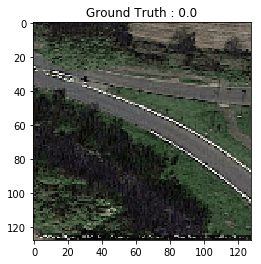

In [329]:
plt.imshow(images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(labels[0]))

The following functions will be used to pre-process the data and create the mixed-input neural network architecture.

In [343]:
def process_structured_data(df, train, test):
    """
    Pre-processes the given dataframe by minmaxscaling the continuous features (fit-transforming the training data and transforming the test data)
    """
    continuous = ["population_per_hectare", "bicycle_aadf", "motor_vehicle_aadf"]
    cs = MinMaxScaler()
    trainX = cs.fit_transform(train[continuous])
    testX = cs.transform(test[continuous])
    return (trainX, testX)

In [375]:
def create_mlp(dim, regularizer=None):
    """Creates a simple two-layer MLP with inputs of the given dimension"""
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(4, activation="relu", kernel_regularizer=regularizer))
    return model

In [376]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regularizer=None):
    """
    Creates a CNN with the given input dimension and filter numbers.
    Adapted from the function described here: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
    """
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    inputShape = (height, width, depth)
    chanDim = -1
 
    # Define the model input
    inputs = Input(shape=inputShape)
 
    # Loop over the number of filters 
    for (i, f) in enumerate(filters):
        # If this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
 
        # Create loops of CONV => RELU => BN => POOL layers
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # Final layers - flatten the volume, then Fully-Connected => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
 
    # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
 
    # Construct the CNN
    model = Model(inputs, x)
 
    # Return the CNN
    return model        

**Conducting the train test split:**

In [337]:
# Using train_test_split to partition the training and testing structured data attributes and images
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df_sorted, images, test_size=0.25, random_state=42)

In [338]:
# Setting the labels for y as the safe column
trainY = trainAttrX["safe"]
testY = testAttrX["safe"]

In [345]:
# Process the structured data
(trainAttrX, testAttrX) = process_structured_data(df_sorted, trainAttrX, testAttrX)

**Building the model:**

In [348]:
# Create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1])
cnn = create_cnn(128, 128, 3)
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [351]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


In [352]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
__________

In [355]:
# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)

In [358]:
# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [360]:
start = datetime.datetime.now()

# compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model
model1_history = model1.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX, testImagesX], testY), epochs=5, batch_size=10)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 [==============================] - 281s 19ms/step - loss: 0.5126 - acc: 0.7554 - val_loss: 0.5566 - val_acc: 0.6880
Epoch 2/5
15000/15000 [==============================] - 297s 20ms/step - loss: 0.4613 - acc: 0.7916 - val_loss: 0.6019 - val_acc: 0.6840
Epoch 3/5
15000/15000 [==============================] - 298s 20ms/step - loss: 0.4468 - acc: 0.8010 - val_loss: 0.6534 - val_acc: 0.6314
Epoch 4/5
15000/15000 [==============================] - 277s 18ms/step - loss: 0.4374 - acc: 0.8090 - val_loss: 0.4843 - val_acc: 0.7658
Epoch 5/5
15000/15000 [==============================] - 281s 19ms/step - loss: 0.4256 - acc: 0.8115 - val_loss: 0.4034 - val_acc: 0.8266
Time taken to run: 0:23:55.493697


In [365]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

In [398]:
def cnn_evaluation(model, history, train_features, train_images, train_labels, test_features, test_images, test_labels, class_names=None, model_name=None):
    """
    Evaluates the performance of a CNN with loss and accuracy plots, a confusion matrix and a classification report for the training and test sets.
    """
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epch = range(1, len(train_acc) + 1)
    plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
    plt.plot(epch, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch, train_loss, 'r.', label='Training loss')
    plt.plot(epch, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    results_test = model.evaluate([test_features, test_images], test_labels)
    print('Test Loss:', results_test[0])
    print('Test Accuracy:', results_test[1])
    
    y_train_pred = np.round(model.predict([train_features, train_images]))
    y_pred = np.round(model.predict([test_features, test_images]))
    
    show_cf(test_labels, y_pred, class_names=class_names, model_name=model_name)
    
    print(classification_report(train_labels, y_train_pred))
    print(classification_report(test_labels, y_pred))

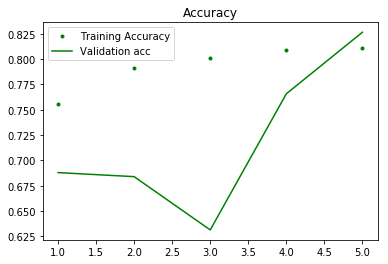

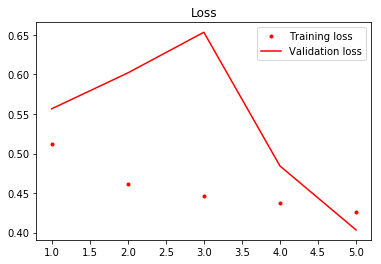

5000/5000 [==============================] - 28s 6ms/step
Test Loss: 0.4034484951257706
Test Accuracy: 0.8266
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2524
           1       0.85      0.79      0.82      2476

   micro avg       0.83      0.83      0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



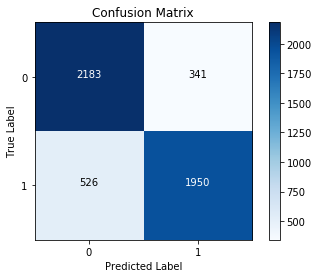

In [371]:
cnn_evaluation(model1, model1_history, testAttrX, testImagesX, testY, class_names=None, model_name=None)

The model is already performing well after only five epochs, but would benefit from additional training. It already has a higher accuracy than the best model using only images (average F1 score of 0.83 vs. 0.77). However, it uses the testing set for validation, so some data leakage may have occurred.

### Model iteration 2

The same model will be run again for additional epochs, to try and improve the accuracy. The validation set will be separated off as the first 1000 instances of the test set.

In [373]:
start = datetime.datetime.now()

model2 = Model(inputs=[mlp.input, cnn.input], outputs=x)

# Compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model2.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# Train the model, and validate with the first 1000 rows of the test set
model2_history = model2.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX[:1000], testImagesX[:1000]], testY[:1000]), epochs=50, batch_size=10)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 15000 samples, validate on 1000 samples
Epoch 1/50
15000/15000 [==============================] - 242s 16ms/step - loss: 0.3964 - acc: 0.8285 - val_loss: 0.4131 - val_acc: 0.8170
Epoch 2/50
15000/15000 [==============================] - 224s 15ms/step - loss: 0.3846 - acc: 0.8375 - val_loss: 0.5731 - val_acc: 0.6820
Epoch 3/50
15000/15000 [==============================] - 220s 15ms/step - loss: 0.3808 - acc: 0.8379 - val_loss: 0.6998 - val_acc: 0.6430
Epoch 4/50
15000/15000 [==============================] - 220s 15ms/step - loss: 0.3527 - acc: 0.8483 - val_loss: 0.5503 - val_acc: 0.7520
Epoch 5/50
15000/15000 [==============================] - 217s 14ms/step - loss: 0.3295 - acc: 0.8639 - val_loss: 0.5839 - val_acc: 0.7230
Epoch 6/50
15000/15000 [==============================] - 214s 14ms/step - loss: 0.3047 - acc: 0.8756 - val_loss: 0.4684 - val_acc: 0.8060
Epoch 7/50
15000/15000 [==============================] - 215s 14ms/step - loss: 0.2801 - acc: 0.8867 - val_loss: 0.4

KeyboardInterrupt: 

The model was force stopped because overfitting is clearly an issue, and validation accuracy stopped improving.

### Model iteration 3

In this iteration of the model, L1 regularization was introduced to reduce overfitting.

In [377]:
# Create the MLP and CNN models
mlp3 = create_mlp(trainAttrX.shape[1], regularizer=regularizers.l1(0.005))
cnn3 = create_cnn(128, 128, 3, regularizer=regularizers.l1(0.005))
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp3.output, cnn3.output])

In [379]:
print(mlp3.summary())
print(cnn3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
activation_6 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_nor

In [386]:
# The final FC layer head will have two dense layers
x = Dense(4, activation="relu", kernel_regularizer=regularizers.l1(0.005))(combinedInput)
x = Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l1(0.005))(x)

In [387]:
# The final model will accept numerical data on the MLP input and images on the CNN input, outputting a single value
model3 = Model(inputs=[mlp3.input, cnn3.input], outputs=x)

In [388]:
start = datetime.datetime.now()

model3 = Model(inputs=[mlp3.input, cnn3.input], outputs=x)

# compile the model 
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model3.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model, and validate with the first 1000 rows of the test set
model3_history = model3.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX[:1000], testImagesX[:1000]], testY[:1000]), epochs=15, batch_size=10)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 15000 samples, validate on 1000 samples
Epoch 1/15
15000/15000 [==============================] - 223s 15ms/step - loss: 2.5254 - acc: 0.6877 - val_loss: 2.3773 - val_acc: 0.7150
Epoch 2/15
15000/15000 [==============================] - 217s 14ms/step - loss: 2.0202 - acc: 0.7440 - val_loss: 1.9498 - val_acc: 0.7840
Epoch 3/15
15000/15000 [==============================] - 219s 15ms/step - loss: 1.9584 - acc: 0.7396 - val_loss: 1.8030 - val_acc: 0.7810
Epoch 4/15
15000/15000 [==============================] - 216s 14ms/step - loss: 1.6637 - acc: 0.7621 - val_loss: 1.4849 - val_acc: 0.7910
Epoch 5/15
15000/15000 [==============================] - 220s 15ms/step - loss: 1.6794 - acc: 0.7742 - val_loss: 1.8095 - val_acc: 0.6250
Epoch 6/15
15000/15000 [==============================] - 220s 15ms/step - loss: 1.5279 - acc: 0.7839 - val_loss: 1.6563 - val_acc: 0.5900
Epoch 7/15
15000/15000 [==============================] - 223s 15ms/step - loss: 1.5475 - acc: 0.7847 - val_loss: 1.5

In [403]:
model3.save('models/mixed_model_v3.h5')

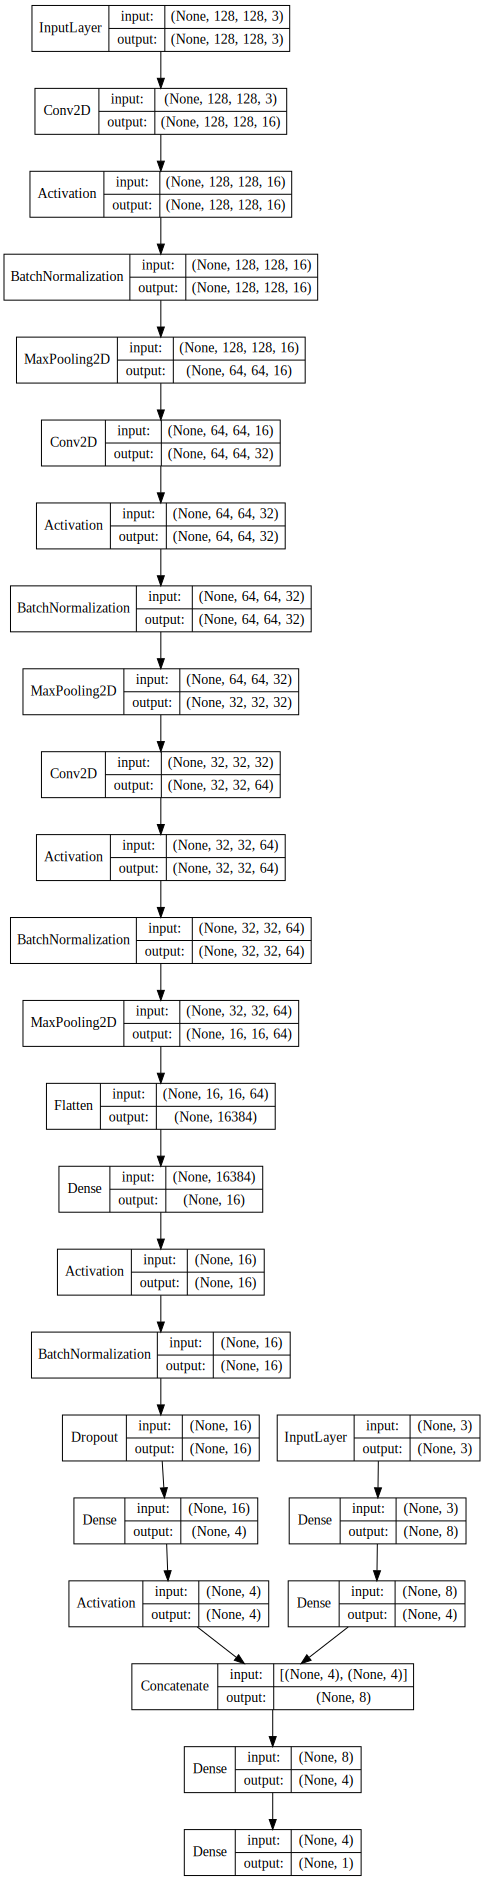

In [3]:
# Visualising the model
SVG(model_to_dot(model3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
plot_model(model3, to_file='models/mixed_model3_v3.png')

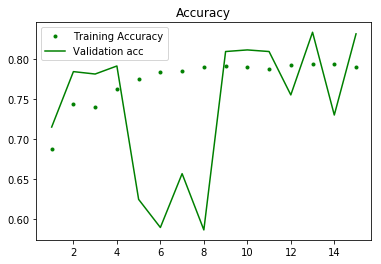

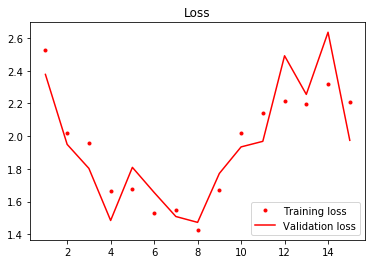

4000/4000 [==============================] - 39s 10ms/step
Test Loss: 2.018479386329651
Test Accuracy: 0.802
              precision    recall  f1-score   support

           0       0.76      0.90      0.83      7476
           1       0.88      0.72      0.80      7524

   micro avg       0.81      0.81      0.81     15000
   macro avg       0.82      0.81      0.81     15000
weighted avg       0.82      0.81      0.81     15000

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      2013
           1       0.86      0.72      0.78      1987

   micro avg       0.80      0.80      0.80      4000
   macro avg       0.81      0.80      0.80      4000
weighted avg       0.81      0.80      0.80      4000



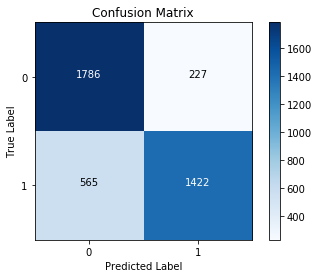

In [399]:
cnn_evaluation(model3, model3_history, trainAttrX, trainImagesX, trainY, testAttrX[1000:], testImagesX[1000:], testY[1000:], class_names=None, model_name=None)

This model still performs well even when the data leakage issue between the validation and test sets has been removed, with an average F1 score of 0.8 for the test set. It also has fewer False Negatives, which is preferred. It also does not suffer from overfitting.

### Model iteration 4

In order to try and improve accuracy, this model adds an extra layer to the final fully-connected layer head, tries using an RMSprop optimizer (as used in CNN model 2), and trains for longer.

In [402]:
start = datetime.datetime.now()

# create the MLP and CNN models
mlp4 = create_mlp(trainAttrX.shape[1], regularizer=regularizers.l1(0.005))
cnn4 = create_cnn(128, 128, 3, regularizer=regularizers.l1(0.005))
 
# create the input to our final set of layers as the *output* of both the MLP and CNN
combinedInput = concatenate([mlp4.output, cnn4.output])


# our final FC layer head will have two dense layers, the final one being our sigmoid head
x = Dense(4, activation="relu", kernel_regularizer=regularizers.l1(0.005))(combinedInput)
x = Dense(4, activation="relu", kernel_regularizer=regularizers.l1(0.005))(x)
x = Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l1(0.005))(x)


# our final model will accept numerical data on the MLP input and images on the CNN input, outputting a single value
model4 = Model(inputs=[mlp4.input, cnn4.input], outputs=x)


# compile the model 
opt = RMSprop(lr=1e-4)
model4.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model, and validate with the first 1000 rows of the test set
model4_history = model4.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX[:1000], testImagesX[:1000]], testY[:1000]), epochs=30, batch_size=10)
 
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 15000 samples, validate on 1000 samples
Epoch 1/30
15000/15000 [==============================] - 350s 23ms/step - loss: 1.7350 - acc: 0.6873 - val_loss: 1.0153 - val_acc: 0.7550
Epoch 2/30
15000/15000 [==============================] - 330s 22ms/step - loss: 1.0521 - acc: 0.7351 - val_loss: 1.0805 - val_acc: 0.7200
Epoch 3/30
15000/15000 [==============================] - 330s 22ms/step - loss: 1.0367 - acc: 0.7494 - val_loss: 1.0293 - val_acc: 0.7580
Epoch 4/30
15000/15000 [==============================] - 331s 22ms/step - loss: 1.0288 - acc: 0.7602 - val_loss: 1.0132 - val_acc: 0.7950
Epoch 5/30
15000/15000 [==============================] - 331s 22ms/step - loss: 1.0352 - acc: 0.7686 - val_loss: 0.9556 - val_acc: 0.8030
Epoch 6/30
15000/15000 [==============================] - 357s 24ms/step - loss: 1.0406 - acc: 0.7710 - val_loss: 0.9497 - val_acc: 0.8080
Epoch 7/30
15000/15000 [==============================] - 256s 17ms/step - loss: 1.0108 - acc: 0.7824 - val_loss: 0.9

In [404]:
model4.save('models/mixed_model_v4.h5')

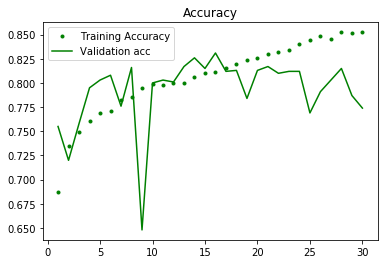

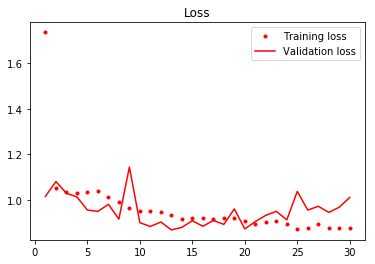

4000/4000 [==============================] - 26s 7ms/step
Test Loss: 1.01718044757843
Test Accuracy: 0.7855
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7476
           1       0.95      0.87      0.90      7524

   micro avg       0.91      0.91      0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      2013
           1       0.82      0.73      0.77      1987

   micro avg       0.79      0.79      0.79      4000
   macro avg       0.79      0.79      0.78      4000
weighted avg       0.79      0.79      0.78      4000



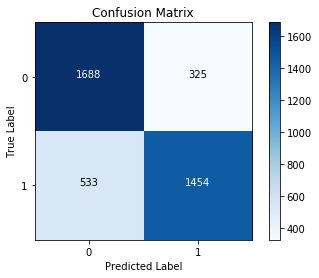

In [405]:
cnn_evaluation(model4, model4_history, trainAttrX, trainImagesX, trainY, testAttrX[1000:], testImagesX[1000:], testY[1000:])

Unfortunately this model performs slightly worse than model iteration 3. Although it achieves a considerably higher score for the training set, there is significant overfitting. Therefore, model iteration 3 is the preferred model.

## Summary and potential directions for future work

The best model produced was version 3, which had an average F1 score of 0.8 and had no overfitting. Versions 2 and 4 both achieved accuracy scores for the training set above 0.9, but they exhibited more overfitting, which is why version 3 is preferred.

This model performs slightly better than the best version of model 2 (0.77), which only used satellite images as inputs and did not include the extra structured data. Therefore, depending on the context, based on the current best versions it might be preferable to put the best version of the CNN-only model into production, rather than the mixed-input model (due to the extra data processing involved in the mixed-input model). However, there is plenty of room for improvement in model 3, including tuning of both the CNN and MLP components, as well as the final fully-connected layers. In particular, model 3 did not benefit from the pre-trained VGG19 model which was used in model 2. Nevertheless, model 3 is a successful proof of concept of the mixed-input approach.

To try and improve the accuracy of the model, some of the following could be tried in further model iterations:
- Adding additional layers to the MLP component (which is currently only two layers)
- Using a pre-trained model as the base for the CNN (which increased accuracy in model 2)
- Parameter tuning of both the CNN and MLP components (e.g. experimenting with regularization and optimization)
- Parameter tuning of the final fully-connected layer head
- Adding additional data to the structured dataset about the local area
- Limiting the 'safe square' part of the dataset to only squares that contain roads of some type, i.e. excluding fields, forests and bodies of water